In [22]:
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from tqdm import tqdm
from sklearn.gaussian_process import *
from sklearn import preprocessing
from multioutput_gp import *
from IPython.display import display
from sklearn.preprocessing import StandardScaler

sns.set_style("darkgrid")

%reload_ext autoreload
%autoreload 2

## Load and preprocess single day df

In [13]:
df = pd.read_csv('data/AIS_2024_01_01.csv')

# Preprocessing (ignore defaults from https://www.navcen.uscg.gov/ais-class-a-reports)
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])
df = df.sort_values(by=['MMSI', 'BaseDateTime'])
df = df[df['COG'] != 360]
df = df[df['SOG'] != 102.3]
df = df[df['LAT'] != 181]
df = df[df['Heading'] != 511]
df = df.dropna()

# Get unique MMSIs
MMSIs = df['MMSI'].unique()
print(f"Number of unique MMSIs: {len(MMSIs)}")


Number of unique MMSIs: 3453


In [14]:
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
15263,3660489,2024-01-01 00:01:47,27.37022,-89.92420,0.0,311.0,0.0,NEPTUNE TLP,IMO0745081,WQGV318,99.0,5.0,89.0,60.0,25.5,99.0,A
28831,3660489,2024-01-01 00:04:47,27.37020,-89.92420,0.0,311.0,0.0,NEPTUNE TLP,IMO0745081,WQGV318,99.0,5.0,89.0,60.0,25.5,99.0,A
50470,3660489,2024-01-01 00:07:47,27.37020,-89.92423,0.0,311.0,0.0,NEPTUNE TLP,IMO0745081,WQGV318,99.0,5.0,89.0,60.0,25.5,99.0,A
91449,3660489,2024-01-01 00:19:44,27.37032,-89.92430,0.0,273.0,0.0,NEPTUNE TLP,IMO0745081,WQGV318,99.0,5.0,89.0,60.0,25.5,99.0,A
538910,3660489,2024-01-01 00:28:44,27.37018,-89.92418,0.0,273.0,0.0,NEPTUNE TLP,IMO0745081,WQGV318,99.0,5.0,89.0,60.0,25.5,99.0,A


In [15]:
# Prints stats
print(f"Number of unique MMSIs: {len(MMSIs)}")
print(f"Total number of rows: {len(df)}")

Number of unique MMSIs: 3453
Total number of rows: 2128288


For each MMSI, compute the seconds since the start of the trajectory

In [16]:
# Dictionary to store MMSI stats
mmsi_stats = {}

def ais_to_state_space(LON, LAT, Heading, SOG):
    x = 111320 * LON
    y = 111320 * LAT
    theta = np.radians(Heading)
    
    x_dot = 0.514444 * SOG * np.cos(theta) # Convert to m/s
    y_dot = 0.514444 * SOG * np.sin(theta) # Convert to m/s
    # print(x, y, theta, x_dot, y_dot)
    return x, y, theta, x_dot, y_dot


for MMSI in tqdm(MMSIs, desc="Formatting dataset into trajectories"):
    single_ship_df = df[df['MMSI'] == MMSI]
    single_ship_df = single_ship_df.sort_values(by='BaseDateTime')
    single_ship_df = single_ship_df.drop_duplicates(subset=['BaseDateTime'], keep='last')
    
    # Compute seconds since start
    earliest_time = single_ship_df['BaseDateTime'].min()
    single_ship_df.head()
    single_ship_df['SecondsSinceStart'] = (single_ship_df['BaseDateTime'] - earliest_time).dt.total_seconds()
    df.loc[single_ship_df.index, 'SecondsSinceStart'] = single_ship_df['SecondsSinceStart']

    # # Apply StandardScaler on LON, LAT, and Heading
    # scaler = preprocessing.StandardScaler()
    # scaled_features = scaler.fit_transform(single_ship_df[['LON', 'LAT', 'Heading']])
    # df.loc[single_ship_df.index, ['Scaled_LON', 'Scaled_LAT', 'Scaled_Heading']] = scaled_features

    # Convert to state-space and add as new column
    # df[['x', 'y', 'theta', 'x_dot', 'y_dot']] = df.apply(
    # lambda row: pd.Series(ais_to_state_space(row['LON'], row['LAT'], row['Heading'], row['SOG'])),
    # axis=1)
    
    # # Estimate theta_dot (rate of change of heading)
    # df = df.sort_values(by=['MMSI', 'BaseDateTime'])  # Ensure data is sorted by MMSI and time
    # df['DeltaTime'] = df.groupby('MMSI')['BaseDateTime'].diff().dt.total_seconds()  # Time difference in seconds
    # df['DeltaTheta'] = df.groupby('MMSI')['theta'].diff()  # Difference in theta (radians)

    # # Handle theta wrap-around (e.g., from -π to π)
    # df['DeltaTheta'] = np.where(df['DeltaTheta'] > np.pi, df['DeltaTheta'] - 2 * np.pi, df['DeltaTheta'])
    # df['DeltaTheta'] = np.where(df['DeltaTheta'] < -np.pi, df['DeltaTheta'] + 2 * np.pi, df['DeltaTheta'])

    # # Compute theta_dot (rate of change of heading in radians per second)
    # df['theta_dot'] = df['DeltaTheta'] / df['DeltaTime']

    # # Drop rows with NaN values caused by diff()
    # df = df.dropna(subset=['DeltaTime', 'DeltaTheta', 'theta_dot'])
    
    # Store mmsi stats
    mmsi_stats[MMSI] = {
        'EarliestTime': earliest_time,
        'LastTime': single_ship_df['BaseDateTime'].max(),
        'TotalDuration': (single_ship_df['BaseDateTime'].max() - earliest_time).total_seconds(),
        'NumRecords': len(single_ship_df),
    }

single_ship_df.head()


Formatting dataset into trajectories: 100%|██████████| 3453/3453 [00:05<00:00, 585.23it/s]


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,SecondsSinceStart
6623886,856583816,2024-01-01 06:39:01,41.14585,-71.74343,11.7,206.3,199.0,CT PILOT_US,IMO1245184,WTE9495,0.0,0.0,42.0,0.0,0.0,0.0,A,0.0
2156147,856583816,2024-01-01 06:49:50,41.11886,-71.76982,11.1,207.8,212.0,CT PILOT_US,IMO1245184,WTE9495,0.0,0.0,42.0,0.0,0.0,0.0,A,649.0
1815561,856583816,2024-01-01 06:53:01,41.11054,-71.77662,11.0,218.1,218.0,CT PILOT_US,IMO1245184,WTE9495,0.0,0.0,42.0,0.0,0.0,0.0,A,840.0
1828330,856583816,2024-01-01 06:56:47,41.10090,-71.77897,10.8,208.4,203.0,CT PILOT_US,IMO1245184,WTE9495,0.0,0.0,42.0,0.0,0.0,0.0,A,1066.0
2215943,856583816,2024-01-01 06:58:20,41.09647,-71.78163,10.9,201.8,202.0,CT PILOT_US,IMO1245184,WTE9495,0.0,0.0,42.0,0.0,0.0,0.0,A,1159.0


In [17]:
# Find the MMSI with the second most records
mmsi_stats
sorted_mmsi_stats = sorted(mmsi_stats.items(), key=lambda x: x[1]['NumRecords'], reverse=True)
# max_records_mmsi = max(mmsi_stats, key=lambda k: mmsi_stats[k]['NumRecords'])
# max_records_mmsi
sorted_mmsi_stats[0]

(np.int64(366921510),
 {'EarliestTime': Timestamp('2024-01-01 00:00:00'),
  'LastTime': Timestamp('2024-01-01 23:59:09'),
  'TotalDuration': 86349.0,
  'NumRecords': 1386})

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,...,TransceiverClass,SecondsSinceStart,x,y,theta,x_dot,y_dot,DeltaTime,DeltaTheta,theta_dot
1,367636710,2024-01-01 06:05:12,39.26967,-76.58035,2.6,353.9,121.0,ERIC MCALLISTER,IMO9707493,WDH6317,...,A,64.0,67.9052,110.2068,2.111848,-0.688891,1.146508,64.0,-1.675516,-0.026180
2,367636710,2024-01-01 06:06:15,39.26955,-76.57819,6.7,103.3,109.0,ERIC MCALLISTER,IMO9707493,WDH6317,...,A,127.0,308.3564,96.8484,1.902409,-1.122160,3.258990,63.0,-0.209440,-0.003324
3,367636710,2024-01-01 06:07:16,39.26828,-76.57661,6.7,153.1,157.0,ERIC MCALLISTER,IMO9707493,WDH6317,...,A,188.0,484.2420,-44.5280,2.740167,-3.172773,1.346762,61.0,0.837758,0.013734
4,367636710,2024-01-01 06:08:18,39.26636,-76.57574,7.2,159.3,159.0,ERIC MCALLISTER,IMO9707493,WDH6317,...,A,250.0,581.0904,-258.2624,2.775074,-3.457979,1.327394,62.0,0.034907,0.000563
5,367636710,2024-01-01 06:09:28,39.26400,-76.57500,8.2,170.6,170.0,ERIC MCALLISTER,IMO9707493,WDH6317,...,A,320.0,663.4672,-520.9776,2.967060,-4.154353,0.732525,70.0,0.191986,0.002743


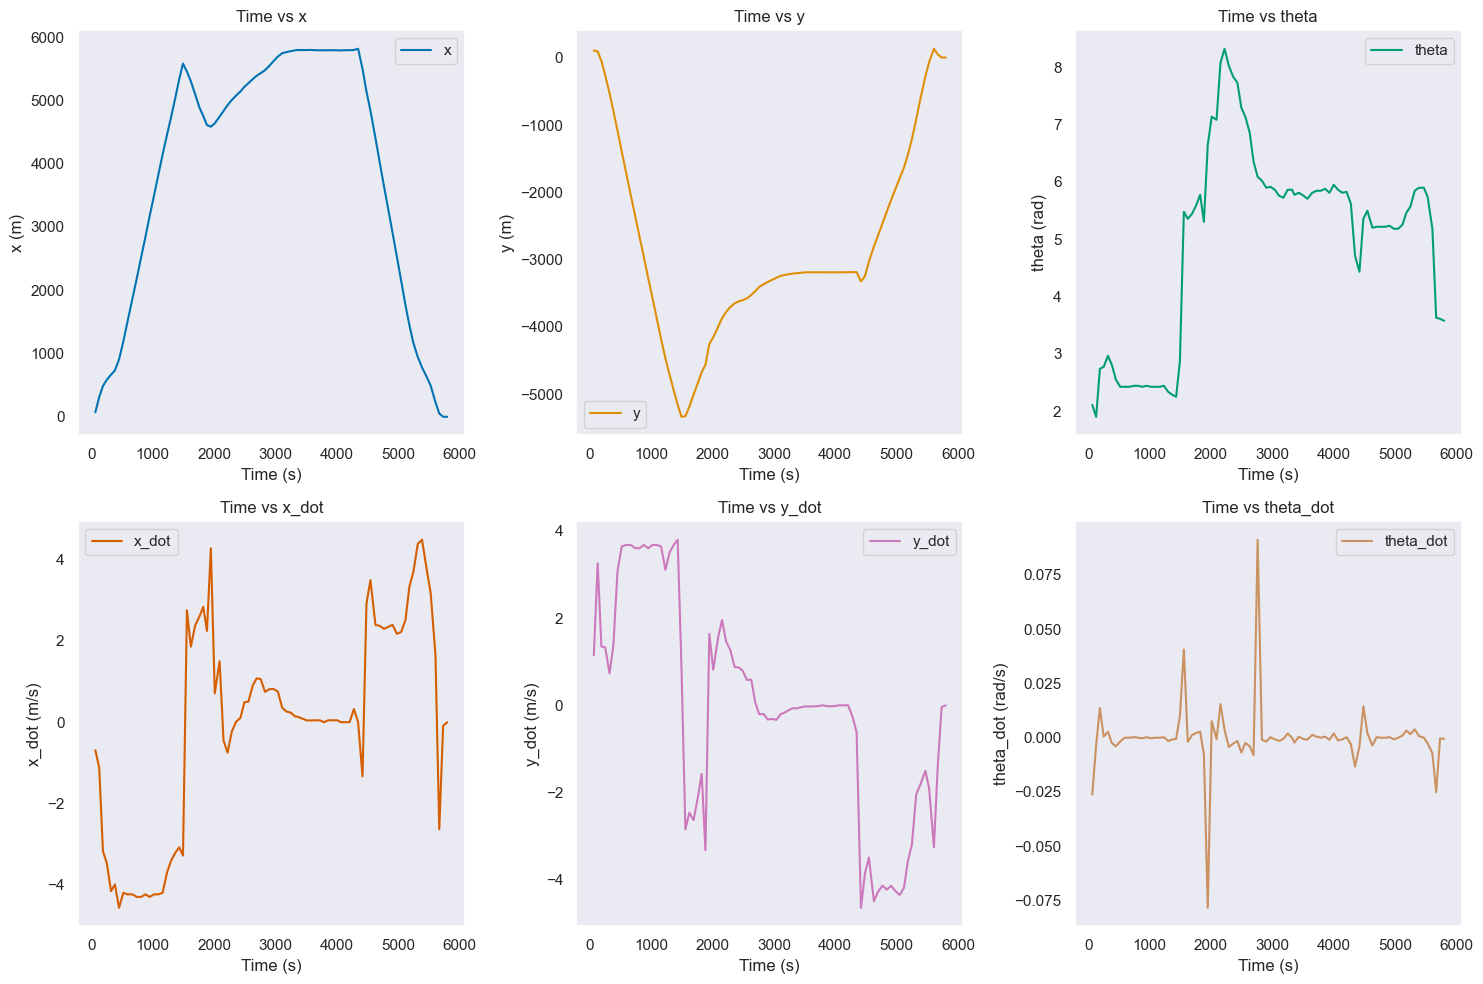

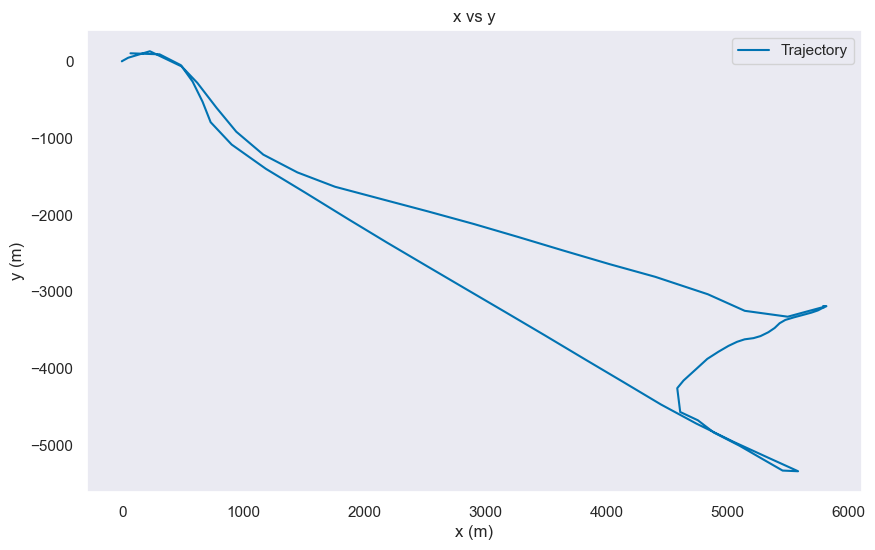

In [18]:
from cycler import cycler
import seaborn as sns

single_ship_df = df[df['MMSI'] == sorted_mmsi_stats[3000][0]]
# single_ship_df = single_ship_df.dropna()
single_ship_df = single_ship_df.reset_index(drop=True)
# Compute state space for single ship
# single_ship_df.loc[:,['x', 'y', 'theta', 'x_dot', 'y_dot']] = single_ship_df.apply(
#     lambda row: pd.Series(ais_to_state_space(row['LON'], row['LAT'], row['Heading'], row['SOG'])),
#     axis=1
# )

x_vals, y_vals, theta_vals, x_dot_vals, y_dot_vals = [], [], [], [], []

for _, row in single_ship_df.iterrows():
    x, y, theta, x_dot, y_dot = ais_to_state_space(row['LON'], row['LAT'], row['Heading'], row['SOG'])
    x_vals.append(x)
    y_vals.append(y)
    theta_vals.append(theta)
    x_dot_vals.append(x_dot)
    y_dot_vals.append(y_dot)

single_ship_df['x'] = x_vals
single_ship_df['y'] = y_vals
single_ship_df['theta'] = theta_vals
single_ship_df['x_dot'] = x_dot_vals
single_ship_df['y_dot'] = y_dot_vals

# Subtract initial x and y values
initial_x = single_ship_df['x'].iloc[0]
initial_y = single_ship_df['y'].iloc[0]

single_ship_df['x'] -= initial_x
single_ship_df['y'] -= initial_y

# Estimate theta_dot (rate of change of heading)
single_ship_df = single_ship_df.sort_values(by='BaseDateTime')  # Ensure data is sorted by time
single_ship_df['DeltaTime'] = single_ship_df['BaseDateTime'].diff().dt.total_seconds()  # Time difference in seconds
single_ship_df['DeltaTheta'] = single_ship_df['theta'].diff()  # Difference in theta (radians)

# # Handle theta wrap-around (e.g., from -π to π)
# single_ship_df['DeltaTheta'] = np.where(single_ship_df['DeltaTheta'] > np.pi, single_ship_df['DeltaTheta'] - 2 * np.pi, single_ship_df['DeltaTheta'])
# single_ship_df['DeltaTheta'] = np.where(single_ship_df['DeltaTheta'] < -np.pi, single_ship_df['DeltaTheta'] + 2 * np.pi, single_ship_df['DeltaTheta'])

# Unwrap the theta column
single_ship_df['theta_unwrapped'] = np.unwrap(single_ship_df['theta'])

# Optionally replace the original theta column with the unwrapped version
single_ship_df['theta'] = single_ship_df['theta_unwrapped']
single_ship_df = single_ship_df.drop(columns=['theta_unwrapped'])

# Compute theta_dot (rate of change of heading in radians per second)
single_ship_df['theta_dot'] = single_ship_df['DeltaTheta'] / single_ship_df['DeltaTime']

# Drop rows with NaN values caused by diff()
single_ship_df = single_ship_df.dropna(subset=['DeltaTime', 'DeltaTheta', 'theta_dot'])


display(single_ship_df.head())


# Use seaborn colorblind palette
colors = sns.color_palette("colorblind", 6)

# Plot time vs x, y, theta, x_dot, y_dot, theta_dot
plt.figure(figsize=(15, 10))

# Plot x
plt.subplot(2, 3, 1)
plt.plot(single_ship_df['SecondsSinceStart'], single_ship_df['x'], label='x', color=colors[0])
plt.xlabel('Time (s)')
plt.ylabel('x (m)')
plt.title('Time vs x')
plt.grid()
plt.legend()

# Plot y
plt.subplot(2, 3, 2)
plt.plot(single_ship_df['SecondsSinceStart'], single_ship_df['y'], label='y', color=colors[1])
plt.xlabel('Time (s)')
plt.ylabel('y (m)')
plt.title('Time vs y')
plt.grid()
plt.legend()

# Plot theta
plt.subplot(2, 3, 3)
plt.plot(single_ship_df['SecondsSinceStart'], single_ship_df['theta'], label='theta', color=colors[2])
plt.xlabel('Time (s)')
plt.ylabel('theta (rad)')
plt.title('Time vs theta')
plt.grid()
plt.legend()

# Plot x_dot
plt.subplot(2, 3, 4)
plt.plot(single_ship_df['SecondsSinceStart'], single_ship_df['x_dot'], label='x_dot', color=colors[3])
plt.xlabel('Time (s)')
plt.ylabel('x_dot (m/s)')
plt.title('Time vs x_dot')
plt.grid()
plt.legend()

# Plot y_dot
plt.subplot(2, 3, 5)
plt.plot(single_ship_df['SecondsSinceStart'], single_ship_df['y_dot'], label='y_dot', color=colors[4])
plt.xlabel('Time (s)')
plt.ylabel('y_dot (m/s)')
plt.title('Time vs y_dot')
plt.grid()
plt.legend()

# Plot theta_dot
plt.subplot(2, 3, 6)
plt.plot(single_ship_df['SecondsSinceStart'], single_ship_df['theta_dot'], label='theta_dot', color=colors[5])
plt.xlabel('Time (s)')
plt.ylabel('theta_dot (rad/s)')
plt.title('Time vs theta_dot')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Plot x vs y
plt.figure(figsize=(10, 6))
plt.plot(single_ship_df['x'], single_ship_df['y'], label='Trajectory', color=colors[0])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('x vs y')
plt.grid()
plt.legend()
plt.show()


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

train_x = torch.tensor(single_ship_df['SecondsSinceStart'].values, dtype=torch.float32).reshape(-1, 1)
scaler = StandardScaler()
train_x = torch.tensor(scaler.fit_transform(train_x), dtype=torch.float32)
display(train_x.shape)

train_y = torch.tensor(single_ship_df[['x', 'y', 'theta', 'x_dot', 'y_dot', 'theta_dot']].values, dtype=torch.float32)
train_y.shape

# train_y= torch.tensor(scaler.fit_transform(train_y), dtype=torch.float32)



Using device: cpu


torch.Size([85, 1])

torch.Size([85, 6])

## Define likelihood and model

In [20]:
num_outputs = train_y.size(-1)
print(f"Number of outputs: {num_outputs}")
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_outputs, noise_prior=gpytorch.priors.NormalPrior(loc=0.5, scale=5.0))
# likelihood.noise = torch.tensor(0.5).to(device)  # Set noise to a fixed value
model = MultiOutputExactGPModel(train_x, train_y, likelihood, num_outputs)

Number of outputs: 6


## Train Model

In [21]:
model, likelihood = train_model(model, likelihood, train_x, train_y, num_epochs=1000, lr=0.01)

GP Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/gp/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/gp/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
GP Training Progress: 100%|██████████| 1000/1000 [00:09<00:00, 108.37it/s]


ValueError: too many values to unpack (expected 2)

In [ ]:
print("Kernel Parameters:")
print(model.covar_module.state_dict())


Kernel Parameters:
OrderedDict({'task_covar_module.covar_factor': tensor([[-4.9086e+00],
        [ 3.4465e+00],
        [-3.9152e-03],
        [-4.8296e-04],
        [-1.5028e-04],
        [ 1.6069e-03]]), 'task_covar_module.raw_var': tensor([ 1.6569,  1.4230,  0.1853,  0.7377, -0.9002,  1.0274]), 'task_covar_module.raw_var_constraint.lower_bound': tensor(0.), 'task_covar_module.raw_var_constraint.upper_bound': tensor(inf), 'data_covar_module.raw_lengthscale': tensor([[-0.6660]]), 'data_covar_module.raw_lengthscale_constraint.lower_bound': tensor(0.), 'data_covar_module.raw_lengthscale_constraint.upper_bound': tensor(inf)})


torch.Size([500, 1])


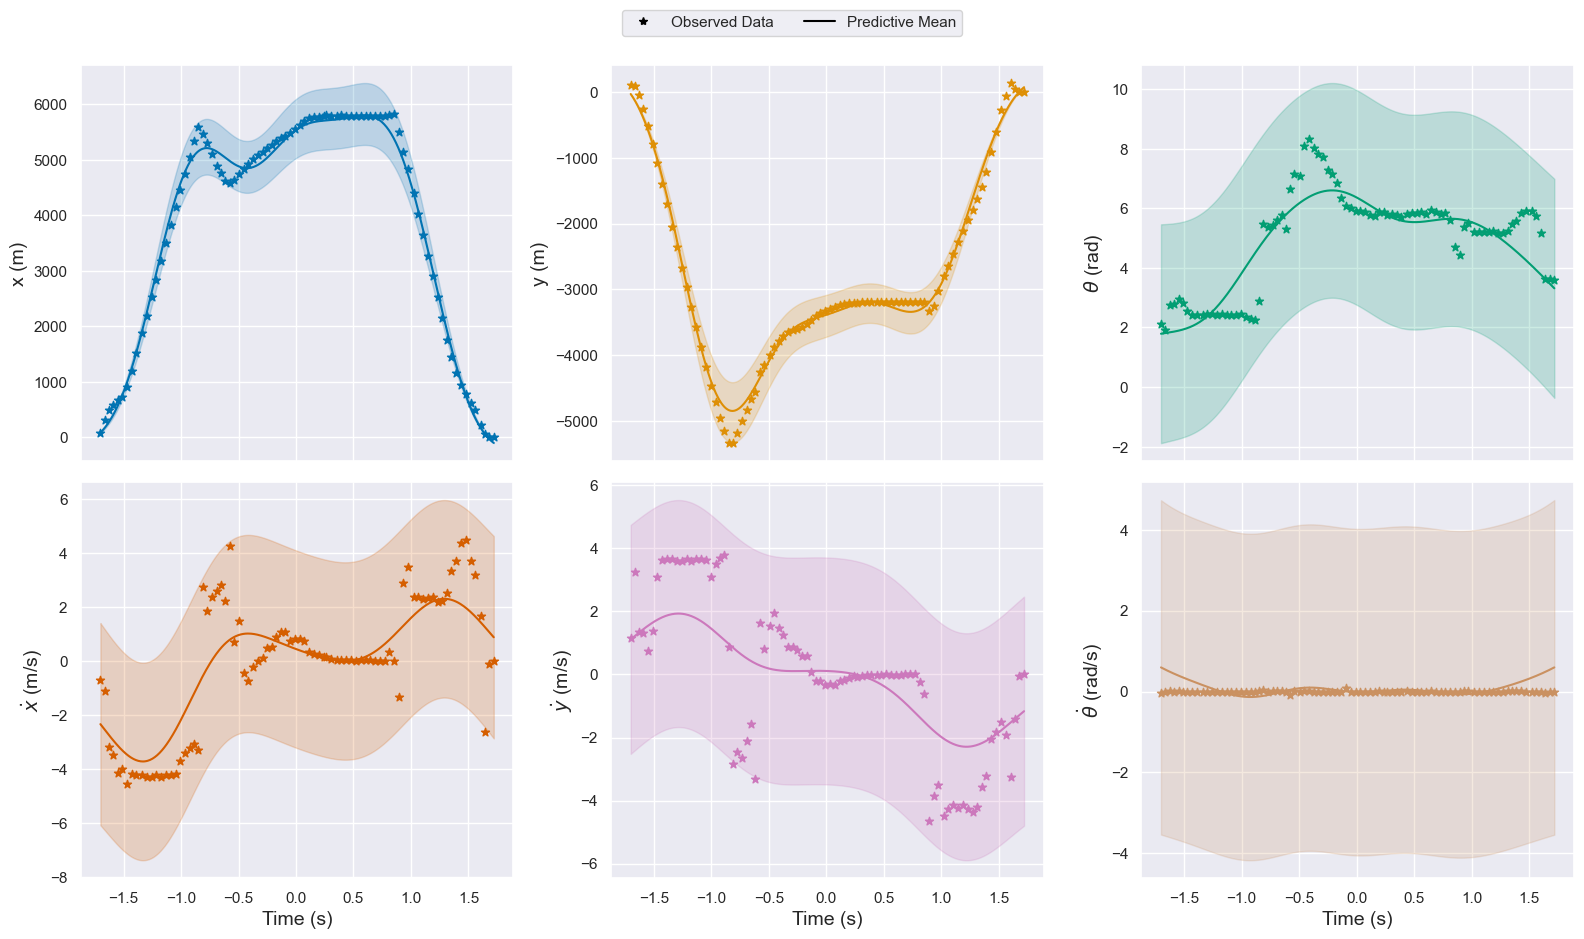

In [ ]:
# Generate test set with the same range as train_x
test_x = torch.linspace(train_x.min(), train_x.max(), steps=500).reshape(-1, 1)
print(test_x.shape)

# Make predictions
observed_pred = eval_model(model, likelihood, test_x)

plot_gp(train_x, train_y, test_x, observed_pred)

In [ ]:
print("Kernel Hyperparameters:")
print(model.covar_module)

Kernel Hyperparameters:
MultitaskKernel(
  (task_covar_module): IndexKernel(
    (raw_var_constraint): Positive()
  )
  (data_covar_module): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
)
